## Stable Diffusion. What's the hype ? 

Diffusion models are quite in the hype for Text-to-Image generation. We all have seen the weird videos on the Internet of Text-to-Image generation, but how does it even work ?

### Noising and Denoising : 
We'll start with the easy part. Denoising refers to process of removing noise from the image and Noising refers to the process of adding noise to an image. That sounds easy. Can there be any problem in this simple task ?

It turns out that generally, the image synthesis tasks are performed by deep geenrative models(such as GANs, VAEs, and autoregressive models) which has its downsides when trained to synthsize high quality samples on difficult, high resolution datasets. 

Maybe - we can just break down this process of noising and denoising into smaller, managable chunks ? ...  

### What is Diffusion ?

The answer to the last question is **Diffusion models**. 

The idea behind diffusion is quite simple. Firstly, we'll start with corrupting the training data iteratively by adding gaussian noise, slowly wiping out the details till it becomes pure noise, and then training a model to reverse this corruption process(which is also done iteratively) 

This process of de-corrupting the image is also quite clever and happens over several iterations. Instead of directly generating the image, (which can be quite not so accurate and have some ambiguities) we ask the denoising model(also called backward process) to try to predict the noise itself !(again, keep in mind that this is done at a particular iteration). Then , we just subtract the noise from the image.

It turns out that this is much more accurate than directly generating the image. 

## How do we go from Diffusion to Text-to-Image Generation ?

This is also done in  a clever way. Together with image that needs to be diffused, we put together the text associated with the image (after converting it to embeddings) into a model and guide the diffusion model towards some target class. This gives us an denoised image which is closely related to the caption as well. However complicated it sounds, it is done through a rather simple and **VERY** clever technique called **Classifier Guidance**. 

### Classifier Guidance : 
In Stable Diffusion, we make use of something called **CLIP** embeddings to guide the diffusion towards the target class during the training. CLIP stands for Contrastive Loss Image Pair. The ideas behind this is to make the image and word embeddings similar in their semantics. Similar CLIP embeddings are used in DALL-E as well.   


#### Generation of never seen images - Classifier Free Guidance :
One question that is often asked when people see Text-To-Image generation is - How can it come up with images it has never seen before ? As with everything in this notebook - this was also done using a clever technique called **Classifier Free Guidance**.

In Classifier free guidance - instead of one noisy image, two same images are fed to model - one without the text embeddings and one with it. The diffusion model therefore comes up with two image - one without text embeddings and one without it. Together, these two noise images* can be used to amplifiy the signal and generate images which are previously not generated.




*Rememer that the model generates noise, not the actual image

## Phewwww !! That's a lot of theory !
Now we'll move on the implementation part. 

In [2]:
# Necessary Library for the notebook !
!pip install transformers diffusers lpips 

# For interactive notebooks !
!jupyter nbextension enable --py widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.9/304.9 kB 6.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.4 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# Stable Diffusion models are openly avaialble via HuggingFace

# Login into your HuggingFace account through this notebook !
from huggingface_hub import notebook_login
notebook_login()

In [4]:
# Necessary Libraries : 

!huggingface-cli whoami  ## Just make sure you are logged in !

import numpy
from tqdm.auto import tqdm

import torch
from torch import autocast
from torchvision import transforms as tfms

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline

from PIL import Image
from matplotlib import pyplot as plt

# For video display:
from IPython.display import HTML
from base64 import b64encode

# For interactive notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Set device - Make sure to set the runtime to GPU in the Kaggle Notebook !
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch_device)

yash-srivastava19
cuda


## Setting up the Diffusion Models and Text Embeddings.

- VAE(Variational Auto Encoder) : The Encoder-Decoder Model for noising and denoising the image.
- Tokenizer : As discussed above, we will be using Contrastive Loss Image Pair(CLIP) embeddings.
- UNet : UNet model is for generating the latents

This process is simplied in the `StableDiffusionPipeline` in the `diffusers` package. It implements all of VAE, Tokenizer, UNet in a single pipeline.

Other things which need some setting up :
- For this, we can use LMS(Least Mean Square) Dicrete Scheduler.

In [5]:
# Use the scheduler in stableDiff pipeline
# scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
stable_diff_pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4')

stable_diff_pipe.to(torch_device)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.7.2",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Inference

With the prompt now set, run the cell below!

  0%|          | 0/51 [00:00<?, ?it/s]

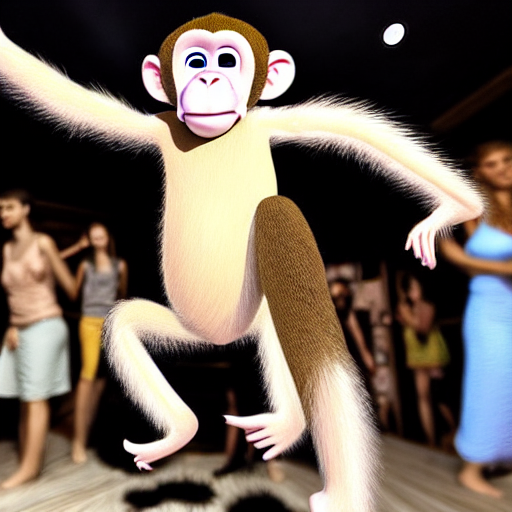

In [6]:
prompt = ['A monkey dancing in a club']   # Change this and Enjoy !!
guidance_scale = 12.5

# Change the seed parameter to create an original image each time.
generator = torch.manual_seed(69)    # Nice !

# Loop
with autocast("cuda"):
    image = stable_diff_pipe(prompt, guidance_scale = guidance_scale).images[0]
    

# Display the image.
image

### Resources :

- [HuggingFace-Stable Diffusion](https://huggingface.co/CompVis/stable-diffusion-v1-4)
- [Pytorch Documentation](https://pytorch.org/docs/stable/index.html)
- [Classifier-Free Guidance](https://openreview.net/pdf?id=qw8AKxfYbI)
- [How Diffusion Models Work ?](https://theaisummer.com/diffusion-models/)
- [High Fidelity Image Generation using Diffusion Models](https://ai.googleblog.com/2021/07/high-fidelity-image-generation-using.html)
- [High Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/pdf/2112.10752.pdf)

